## Simple Shape circuit Extraction Demo notebook

In [1]:
#hardware
device = 'cuda:0'

#model loading
from torchvision import models
model = models.alexnet(pretrained=True)
model = model.to(device)

from copy import deepcopy
from circuit_pruner.dissected_Conv2d import dissect_model
dissected_model = dissect_model(deepcopy(model), store_ranks = True, device=device)
dissected_model = dissected_model.to(device)

/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/torch/cuda/__init__.py:125: UserWarning: 
Tesla K40c with CUDA capability sm_35 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 compute_37.
If you want to use the Tesla K40c GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


this function will show us how to reference layers in our model

In [2]:
from circuit_pruner.force import show_model_layer_names

show_model_layer_names(model)

All Layers:

features
features_0
features_1
features_2
features_3
features_4
features_5
features_6
features_7
features_8
features_9
features_10
features_11
features_12
avgpool
classifier
classifier_0
classifier_1
classifier_2
classifier_3
classifier_4
classifier_5
classifier_6

Convolutional and Linear layers:

('features_0', '  conv')
('features_3', '  conv')
('features_6', '  conv')
('features_8', '  conv')
('features_10', '  conv')
('classifier_1', '  linear')
('classifier_4', '  linear')
('classifier_6', '  linear')


['features',
 'features_0',
 'features_1',
 'features_2',
 'features_3',
 'features_4',
 'features_5',
 'features_6',
 'features_7',
 'features_8',
 'features_9',
 'features_10',
 'features_11',
 'features_12',
 'avgpool',
 'classifier',
 'classifier_0',
 'classifier_1',
 'classifier_2',
 'classifier_3',
 'classifier_4',
 'classifier_5',
 'classifier_6']

### Circle Scale circuits

Identity of our target 'spiral detector' neuron

In [3]:
layer = 'features_8'
unit = 53

visualization of 'spiral' target neuron

  0%|          | 2/512 [00:00<00:33, 15.25it/s]

positive visualization


100%|██████████| 512/512 [00:27<00:00, 18.31it/s]



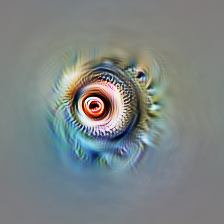

  0%|          | 2/512 [00:00<00:31, 16.17it/s]

negative visualization


100%|██████████| 512/512 [00:28<00:00, 18.24it/s]



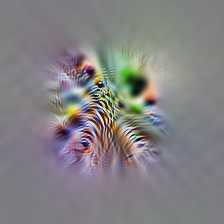

In [30]:
from lucent_fresh.optvis import render, param, transform, objectives   #lucent fresh is a version of lucent with some of my edits
from lucent_fresh.modelzoo.util import get_model_layers

param_f = lambda: param.image(224)
obj  = objectives.neuron(layer,unit)
neg_obj = -obj
print('positive visualization')
_ = render.render_vis(dissected_model,  obj, param_f, transforms=None, show_inline=True) #weird hack here using the 'dissected_model' works better for neuron-wise feature visualizations, not sure why
print('negative visualization')
_ = render.render_vis(dissected_model,  neg_obj, param_f, transforms=None, show_inline=True)

We extract circuits with respect to input images, lets look at the two images we'll use

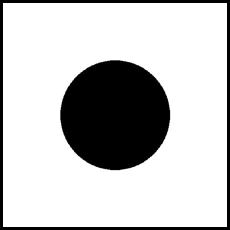

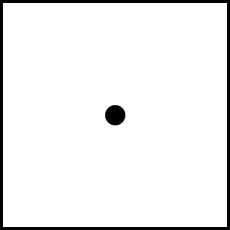

In [4]:
root_image_folder = 'image_data/sample_data/circles/'

from PIL import Image, ImageOps
big_circle_img = Image.open(root_image_folder+'big_circle.jpg')
small_circle_img = Image.open(root_image_folder+'small_circle.jpg')
big_circle_img = big_circle_img.resize((224,224))
small_circle_img = small_circle_img.resize((224,224))


#displaying with a border to get a sense of scale within image
border = (3, 3, 3, 3)
big_circle_wt_border = ImageOps.expand(big_circle_img, border=border, fill='black')
small_circle_wt_border = ImageOps.expand(small_circle_img, border=border, fill='black')
display(big_circle_wt_border)
display(small_circle_wt_border)

circle_images = {'big':big_circle_img,'small':small_circle_img}

One thing that comes up again and again, which we will utilize here, is the calculation of analytical receptive fields. For example, the above images have dots drawn in the center at different sizes, but it is unclear how these dots line up with the receptive field of our target 'spiral' neuron (there is a unique receptive field in pixel space associated with each activation in the activation map for this neuron). What we'd like to do is resize and position the above images on a blank 224x224 image, such that they exactly line-up with a particular receptive field for one activation in the activation map of our target neuron. To do this, we need to know exactly where these receptive fields are in pixel space. Luckily, these can be calculated from the model architecture analytically, as is done below. 

In [5]:
from circuit_pruner.receptive_fields import receptive_field, receptive_field_for_unit

#calculate analytical receptive field generative params for full model
all_recep_field_params = receptive_field(model.features, (3,224,224))   #takes model (features, cant handle linear modules) and input image size

target_position = [5,5]
#get receptive field for unit at position (5,5) (H,W) in the activation map of our target neuron. 
#In this layer the activation map is 13x13, so position (5,5) is roughly in the middle, although this doesnt matter,
#as long as the receptive field is not near the edge and getting cut off.
#This returns the 'bounds' in pixel space of the receptive field in the form [(H_top,H_bottom),(W_left,W_right)]
recep_field = receptive_field_for_unit(all_recep_field_params, layer, target_position)

print('\n')
print(layer)
print(recep_field)

------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 
        8               [13, 13]       15.5       16.0            99.0 
        9               [13, 13]       15.5       16.0           131.0 
        10              [13, 13]       15.5       16.0           131.0 
        11              [13, 13]       15.5       16.0   

Now we can generate new images such that the original images exactly align with the receptive field associated with the activation in position (6,6) of the activation map of our target neuron. When we then go to extract circuits, we can do so with respect to (get gradients from) the unit at this position.

big


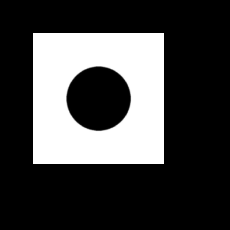

small


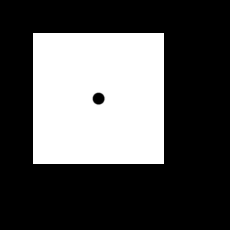

In [6]:
import torch
from torchvision import transforms

#transforms
recep_resize = transforms.Resize((int(recep_field[0][1]-recep_field[0][0]),int(recep_field[1][1]-recep_field[1][0]))) #size of receptive field
totensor = transforms.ToTensor()
topil = transforms.ToPILImage()
norm = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])


cirle_image_tensors = {}
#generate resized/ positioned tensors
for size in circle_images:
    
    #blank backgrounds
    circle_tensor = torch.zeros(3,224,224)
    
    #shrunk images to size of receptive field
    shrunk_circle_tensor = totensor(recep_resize(circle_images[size]))

    #position shrunk images on blanks at receptive field position
    circle_tensor[:,int(recep_field[0][0]):int(recep_field[0][1]),int(recep_field[1][0]):int(recep_field[1][1])] = shrunk_circle_tensor

    #check resultant images (whats actually going to get fed to the model)
    print(size)
    recep_circle_img = topil(circle_tensor)
    recep_circle_wt_border = ImageOps.expand(recep_circle_img, border=border, fill='black')
    display(recep_circle_wt_border)

    # normalize and unsqueeze for passing through model
    circle_tensor = norm(circle_tensor)
    circle_tensor = torch.unsqueeze(circle_tensor,0)
    circle_tensor = circle_tensor.to(device)
    
    cirle_image_tensors[size] = circle_tensor

### By activationsxgradients

The best (and unfortunately slowest) way to calculate saliency scores is by getting activations, which for kernel-wise pruning, requires 'pre-add' activations, which in turns requires a 'dissected_model'.

In [7]:
#dissect model (version of model with intermediate activation maps)
from copy import deepcopy
from circuit_pruner.dissected_Conv2d import dissect_model
dissected_model = dissect_model(deepcopy(model), store_ranks = True, device=device)
dissected_model = dissected_model.to(device)

first we want to just get 'ranks' the sorted importance scores for the components of our network. We can then use those to extract a circuit by thresholding and removing low scoring components. We'll get these scores with respect to a 'small circle' image and a 'large circle' image. The 'dissected' model has the machinery for calculating and storing these scores built in, so we really just have to run the model forward . . .

In [8]:
from circuit_pruner.dissected_Conv2d import set_across_model, set_model_target_node

#setup dissected model hyper params

'''
We set the target in our network to be our feature of interest
'''
set_model_target_node(dissected_model,layer,unit)


"""
We set the 'rank_field' of the model to be [[5,5]], the position in the activation map whose response we'd like
to preserve (in this case, the position that 'sees' our target images). 
Notice we have a list of lists as an argument, this is because we are feeding through minibatches of size 1, 
but if we had bigger minibatches (because we wanted the ranks averaged across a bunch of images) 
we could specify a different position to focus on for each image in the batch.
We also dont have to specify positions at all, we can use the arguments 'image', 'max', or 'min' in place of [[5,5]]
             'image': preserve the average of the activation map
             'max': preserve the max value of the activation map
             'min': preserve the min value of the activation map
             
             default is 'image'
"""
set_across_model(dissected_model,'rank_field',[target_position])


'''
This ones kind of interesting, it means we are going to store the activationsxgradients of our graph components as 
our importance score, rather than the absolute value of that score. This can be useful as we'll see, it could
allow us to find a circuit that increases or decreases the models response to a target image/image patch, 
rather than just preserve the response.
'''
set_across_model(dissected_model,'absolute_rank',False)



AlexNet(
  (features): Sequential(
    (0): dissected_Conv2d(
      (preadd_conv): Conv2d(3, 192, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), groups=3, bias=False)
    )
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): dissected_Conv2d(
      (preadd_conv): Conv2d(64, 12288, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=64, bias=False)
    )
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): dissected_Conv2d(
      (preadd_conv): Conv2d(192, 73728, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=192, bias=False)
    )
    (7): ReLU()
    (8): dissected_Conv2d(
      (preadd_conv): Conv2d(384, 98304, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=384, bias=False)
    )
    (9): ReLU()
    (10): dissected_Conv2d(
      (preadd_conv): Conv2d(256, 65536, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=256, bias=False)
    

In [9]:
#actually extract ranks by running images through model

from circuit_pruner.dissected_Conv2d import get_ranklist_from_dissected_Conv2d_modules, clear_ranks_across_model

ranks = {}
#run images through model
for size in cirle_image_tensors:
    
    in_tensor = cirle_image_tensors[size]
    
    #we want separate ranks for each image, unless we do this, 
    #all ranks are averaged for every image passed through the model.
    clear_ranks_across_model(dissected_model) 
    
    dissected_model.zero_grad()

    #Run model forward until all targets reached, we have this try/except block because the model throws a special
    #error when it reaches all its targets in order to stop the forward pass. This should really be an except
    #that checks for that special error type, but for some reason I cant get that to work across files. (This is very annoying, as it means genuine errors during the forward pass are ignored)
    try:
        outputs = dissected_model(in_tensor)
    except:
        pass
    
    #WHAT ABOUT NO TARGET NODE?
    #just run outputs.backward(), the backward pass triggers hooks through the model


    ranks[size] = get_ranklist_from_dissected_Conv2d_modules(dissected_model)



We can do things with ranks once weve extracted them, like for example calculating a 'diff' rank by simply extracting one from the other. This is why we set 'absolute rank' to False earlier. Now our diff rank will essentially be approximating 'parameters that make the models response to the first image go up, and the response to the second image go down'.

In [37]:
ranks['small-big'] = []
ranks['big-small'] = []

for l in range(len(ranks['small'])):
    ranks['small-big'].append(ranks['small'][l]-ranks['big'][l])
    ranks['big-small'].append(ranks['big'][l]-ranks['small'][l])

In [38]:
#finally lets extract some circuits

from circuit_pruner.extraction import dissected_model_ranks_2_circuit_model

sparsity = .2
feature_targets = {layer:[unit]}    #I know this formatting is weird, it comes from syntax for having linear combinations of units as targets, not shown here

extractions = {}
for size in ranks:
    print(size)
    #returns two formats: a circuit, which is a new smaller neural network, and a simple weight mask
    circuit, mask = dissected_model_ranks_2_circuit_model(ranks[size],sparsity,model,feature_targets,device)
    extractions[size] = {'circuit':circuit,'mask':mask}

big
features_8 effective last layer
target sparsity: 0.2
total params to feature: 86592
kept params in original mask: 17319
original mask: 17319 kernels
effective mask: 11637 kernels
effective_sparsity: 0.1343888580931264
small
features_8 effective last layer
target sparsity: 0.2
total params to feature: 86592
kept params in original mask: 17319
original mask: 17319 kernels
effective mask: 10414 kernels
effective_sparsity: 0.12026515151515152
small-big
features_8 effective last layer
target sparsity: 0.2
total params to feature: 86592
kept params in original mask: 17319
original mask: 17319 kernels
effective mask: 9016 kernels
effective_sparsity: 0.10412047302291205
big-small
features_8 effective last layer
target sparsity: 0.2
total params to feature: 86592
kept params in original mask: 17319
original mask: 17319 kernels
effective mask: 9804 kernels
effective_sparsity: 0.11322062084257206


treat these extracted circuits like new models, you can do all the same stuff with them, like visualizations . . .

  2%|▏         | 9/512 [00:00<00:05, 89.32it/s]

big


100%|██████████| 512/512 [00:05<00:00, 87.18it/s]



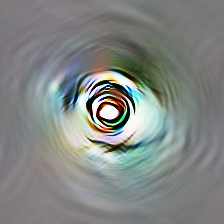

  2%|▏         | 8/512 [00:00<00:07, 70.13it/s]

small


100%|██████████| 512/512 [00:05<00:00, 87.14it/s]



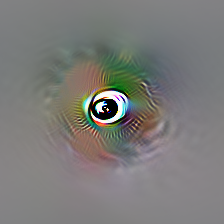

  2%|▏         | 8/512 [00:00<00:06, 76.88it/s]

small-big


100%|██████████| 512/512 [00:05<00:00, 87.49it/s]



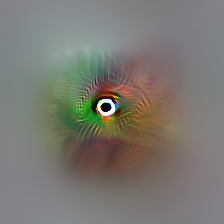

  2%|▏         | 8/512 [00:00<00:06, 72.99it/s]

big-small


100%|██████████| 512/512 [00:05<00:00, 85.92it/s]



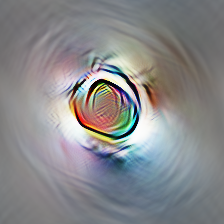

In [39]:
'''
notice we're visualizing the same target node here, but we replace "unit" variable with "0", 
as this layer in the circuit now only has 1 feature, the target node.
'''

obj  = objectives.neuron(layer,0) 


for size in extractions:
    print(size)
    _ = extractions[size]['circuit'].to(device).eval()
    _ = render.render_vis(extractions[size]['circuit'],  obj, param_f, transforms=None, show_inline=True)


what about the negative visualizations?

  2%|▏         | 8/512 [00:00<00:06, 75.27it/s]

big


100%|██████████| 512/512 [00:06<00:00, 84.88it/s]



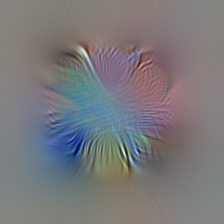

  2%|▏         | 10/512 [00:00<00:05, 95.57it/s]

small


100%|██████████| 512/512 [00:05<00:00, 85.49it/s]



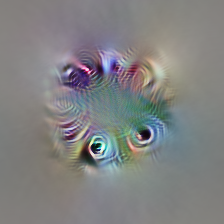

  2%|▏         | 10/512 [00:00<00:05, 97.94it/s]

small-big


100%|██████████| 512/512 [00:05<00:00, 86.07it/s]



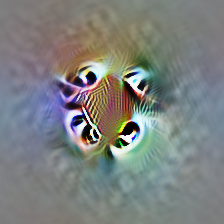

  2%|▏         | 10/512 [00:00<00:05, 96.03it/s]

big-small


100%|██████████| 512/512 [00:06<00:00, 85.29it/s]



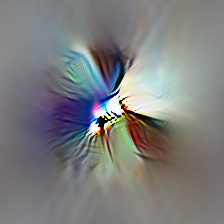

In [40]:

obj  = -objectives.neuron(layer,0) 


for size in extractions:
    print(size)
    _ = extractions[size]['circuit'].to(device).eval()
    _ = render.render_vis(extractions[size]['circuit'],  obj, param_f, transforms=None, show_inline=True)


In [ ]:
# clear some space
del extractions
del ranks

### Squares? 

We've show how separate circuits account for invariance to circle size, what about its variance to squares (filter doesn't like them), can we addition find a circuit for that?

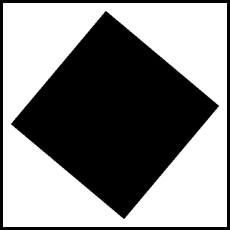

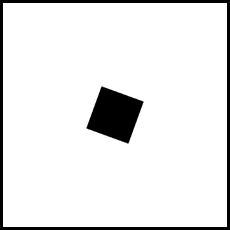

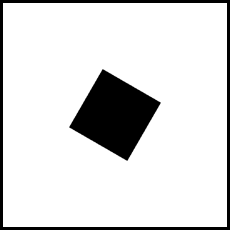

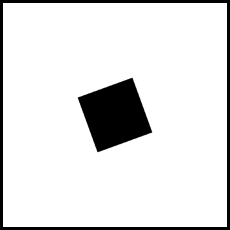

In [13]:
#Making square images
from PIL import Image, ImageOps


    
def make_square_image(square_size = 200,img_size=500,background_c =(255,255,255),square_c=(0,0,0),rot=0):
    background_img = Image.new("RGB", (img_size, img_size), background_c)
    square_img = Image.new("RGB", (square_size, square_size), square_c)
    square_img = square_img.rotate(rot, Image.BILINEAR, expand = 1,fillcolor = background_c)
    pos = (int(img_size/2 - square_img._size[0]/2),int(img_size/2 - square_img._size[1]/2))
    Image.Image.paste(background_img, square_img, pos)
    return background_img


square_params = {
                 'size':[330,100,150,130],
                 'rot': [50,70,60,20]
                }
list

for i in range(len(square_params['size'])):
    square_img = make_square_image(square_size = square_params['size'][i], rot=square_params['rot'][i])
    square_img = square_img.resize((224,224))
    square_img_wt_border = ImageOps.expand(square_img, border=border, fill='black')
    
    display(square_img_wt_border)

how does our circle filter respond to the square across scales and rotations? Well plot a scatter plot of activations as a function of scale and rotation

First we'll use the above square image generator to generate a dataloader with images across scales and rotations

In [43]:
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, utils

totensor = transforms.ToTensor()
topil = transforms.ToPILImage()
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
#transform = transforms.Compose([transforms.ToTensor()])


half_degrees = []
for i in range(181):
    half_degrees.append(i/2)

class square_image_data(Dataset):

    def __init__(self, sizes = list(range(30,330,2)),rotations=half_degrees,background_c =(255,255,255),square_c=(0,0,0), transform=None, recep_field=None, img_size=224):


        self.sizes = sizes
        self.rotations = rotations
        self.background_c = background_c
        self.square_c = square_c
        self.img_size = img_size
        
        self.recep_field = recep_field
        if self.recep_field:
            self.recep_resize = transforms.Resize((int(recep_field[0][1]-recep_field[0][0]),int(recep_field[1][1]-recep_field[1][0]))) #size of receptive field    
        
        if not transform:
            self.transform = transforms.ToTensor()
        else:
            self.transform = transform

    def __len__(self):
        return len(self.sizes)*len(self.rotations)    

    def __getitem__(self, idx):
        rot = self.rotations[(idx // len(self.sizes))]
        size = self.sizes[idx%len(self.sizes)]
        img = make_square_image(square_size = size,background_c = self.background_c,square_c=self.square_c,rot=rot)
        
        if self.recep_field is not None:
            #blank backgrounds
            img_tensor = torch.zeros(3,self.img_size,self.img_size)
            #shrunk images to size of receptive field
            shrunk_tensor = totensor(self.recep_resize(img))
            #position shrunk images on blanks at receptive field position
            img_tensor[:,int(self.recep_field[0][0]):int(self.recep_field[0][1]),int(self.recep_field[1][0]):int(self.recep_field[1][1])] = shrunk_tensor
            img = topil(img_tensor)
     
        img = self.transform(img).float()

        return (img,(size,rot))
    

kwargs = {'num_workers': 4, 'pin_memory': True, 'sampler':None} if 'cuda' in device else {}


dset = square_image_data(transform = transform,recep_field = recep_field)
square_loader = data.DataLoader(dset,
                                batch_size=500,
                                shuffle=False,
                                **kwargs)


In [44]:
'''


test_dset = square_image_data(sizes = [200,200],rotations = [0,90],transform = transform,recep_field = recep_field)
test_loader = data.DataLoader(test_dset,
                                batch_size=2,
                                shuffle=False,
                                **kwargs)

iter_dataloader = iter(test_loader)
iters = len(iter_dataloader)

#for it in range(iters):

inputs, img_data = next(iter_dataloader)
torch.all(inputs[0]== inputs[1])
#     img = inputs[it]
#     img = topil(img)
#     img_wt_border = ImageOps.expand(img, border=border, fill='black')
#     print((int(img_data[0][it]),int(img_data[1][it])))
#     display(img_wt_border)

'''


"\n\n\ntest_dset = square_image_data(sizes = [200,200],rotations = [0,90],transform = transform,recep_field = recep_field)\ntest_loader = data.DataLoader(test_dset,\n                                batch_size=2,\n                                shuffle=False,\n                                **kwargs)\n\niter_dataloader = iter(test_loader)\niters = len(iter_dataloader)\n\n#for it in range(iters):\n\ninputs, img_data = next(iter_dataloader)\ntorch.all(inputs[0]== inputs[1])\n#     img = inputs[it]\n#     img = topil(img)\n#     img_wt_border = ImageOps.expand(img, border=border, fill='black')\n#     print((int(img_data[0][it]),int(img_data[1][it])))\n#     display(img_wt_border)\n\n"

We are ready to get activations from our target circle feature, let's do that with a version of the model that's not 'dissected', as that runs slow. We'll use this machinery later to extract circuits from our model in another way

In [45]:
from circuit_pruner.force import setup_net_for_circuit_prune, show_model_layer_names

from torchvision import models
model = models.alexnet(pretrained=True)
model = model.to(device)

prunable_model = deepcopy(model)
_ = prunable_model.to(device)

feature_targets = {layer:[unit]}

setup_net_for_circuit_prune(prunable_model, feature_targets=feature_targets,save_target_activations=True)

features_8 effective last layer


passing data through the model will now automatically save target feature activations

In [46]:
from circuit_pruner.force import TargetReached, get_saved_target_activations_from_net
import numpy as np

#activations_list = []
#rotations_list = []
#sizes_list = []
activations = np.zeros((len(dset.sizes),len(dset.rotations)))

iter_dataloader = iter(square_loader)
iters = len(iter_dataloader)

for it in range(iters):

    inputs, img_data = next(iter_dataloader)
    inputs = inputs.to(device)
    try:
        output = prunable_model(inputs)
    except TargetReached:
        pass
    acts = get_saved_target_activations_from_net(prunable_model)[layer+':'+str(unit)].cpu().detach().numpy().astype('float32')
    acts_at_pos = list(acts[:,target_position[0],target_position[1]])
    for i in range(len(acts_at_pos)):
        size_ind = dset.sizes.index(img_data[0].numpy()[i])
        rot_ind = dset.rotations.index(img_data[1].numpy()[i])
        activations[size_ind,rot_ind] = acts_at_pos[i]              
    #activations_list += list(acts_at_pos) 
    #sizes_list += list(img_data[0].numpy())
    #rotations_list += list(img_data[1].numpy())


In [48]:
import plotly.graph_objects as go

import pandas as pd



fig = go.Figure(data=[go.Surface(z=activations,x=dset.rotations, y=dset.sizes)])

fig.update_layout(title='circle feature activations to square (by rotation and size)',
                  scene = dict(
                    xaxis_title="Rotation (degrees)",
                    yaxis_title="Size",
                    zaxis_title='Activation'),
                    scene_aspectmode='cube')



fig.show()

In [49]:
fig.write_html("plots/circle_feature_square_acts.html")

Seems like there are two big wells around diamonds at 2 sizes. Lets make a subgraph that will try to preserve the one of these 'well' (mimimum is at size 180, rot 75 deg, with ~-30 activation)

In [50]:
#get data

minsquare_dset = square_image_data(sizes =  list(range(120,240,10)), rotations = list(range(65,85,2)), transform = transform,recep_field = recep_field)
minsquare_loader = data.DataLoader(minsquare_dset,
                                batch_size=5,
                                shuffle=False,
                                **kwargs)



In [51]:
#get ranks

from circuit_pruner.dissected_Conv2d import get_ranklist_from_dissected_Conv2d_modules, clear_ranks_across_model


clear_ranks_across_model(dissected_model)   
dissected_model.zero_grad()



iter_dataloader = iter(minsquare_loader)
iters = len(iter_dataloader)

#when passing multiple images just run the model and everything will average
for it in range(iters):
    input_batch, img_data = next(iter_dataloader)
    input_batch = input_batch.to(device)
    try:
        outputs = dissected_model(input_batch)
    except:
        pass
    
    #WHAT ABOUT NO TARGET NODE?
    #just run outputs.backward(), the backward pass triggers hooks through the model


minsquare_ranks = get_ranklist_from_dissected_Conv2d_modules(dissected_model)



In [52]:
flipped_minsquare_ranks = []
for i in range(len(minsquare_ranks)):
    flipped_minsquare_ranks.append(-minsquare_ranks[i])
    
abs_minsquare_ranks = []
for i in range(len(minsquare_ranks)):
    abs_minsquare_ranks.append(torch.abs(minsquare_ranks[i]))


In [53]:
#finally lets extract some circuits

from circuit_pruner.extraction import dissected_model_ranks_2_circuit_model

sparsity = .05
feature_targets = {layer:[unit]}    #I know this formatting is weird, it comes from syntax for having linear combinations of units as targets, not shown here


#model loading
from torchvision import models
model = models.alexnet(pretrained=True)
model = model.to(device)

#returns two formats: a circuit, which is a new smaller neural network, and a simple weight mask
circuit, mask = dissected_model_ranks_2_circuit_model(abs_minsquare_ranks,sparsity,model,feature_targets,device)
minsquare_circuit = {'circuit':circuit,'mask':mask}




features_8 effective last layer
target sparsity: 0.05
total params to feature: 86592
kept params in original mask: 4330
original mask: 4330 kernels
effective mask: 2738 kernels
effective_sparsity: 0.03161954915003695


  2%|▏         | 11/512 [00:00<00:04, 100.73it/s]

positive


100%|██████████| 512/512 [00:05<00:00, 89.16it/s]



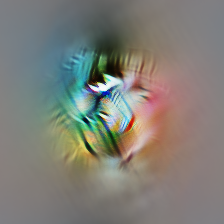

  2%|▏         | 10/512 [00:00<00:05, 95.65it/s]

negative


100%|██████████| 512/512 [00:05<00:00, 90.01it/s]



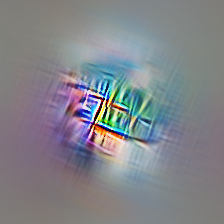

In [54]:
#visualization
from lucent_fresh.optvis import render, param, transform, objectives   #lucent fresh is a version of lucent with some of my edits
from lucent_fresh.modelzoo.util import get_model_layers


param_f = lambda: param.image(224)
obj  = objectives.neuron(layer,unit)

obj  = objectives.neuron(layer,0) #we use 0 as the unit now 


_ = minsquare_circuit['circuit'].to(device).eval()
print('positive')
_ = render.render_vis(minsquare_circuit['circuit'],  obj, param_f, transforms=None, show_inline=True)
print('negative')
_ = render.render_vis(minsquare_circuit['circuit'],  -obj, param_f, transforms=None, show_inline=True)

How do activations to the squares change with our circuits?

In [55]:
from circuit_pruner.force import TargetReached, get_saved_target_activations_from_net
import numpy as np


circuit_model = minsquare_circuit['circuit']

_ = circuit_model.to(device)

circuit_feature_targets = {layer:[0]}

setup_net_for_circuit_prune(circuit_model, feature_targets=circuit_feature_targets,save_target_activations=True)
#activations_list = []
#rotations_list = []
#sizes_list = []
activations = np.zeros((len(dset.sizes),len(dset.rotations)))

iter_dataloader = iter(square_loader)
iters = len(iter_dataloader)

for it in range(iters):

    inputs, img_data = next(iter_dataloader)
    inputs = inputs.to(device)
    try:
        output = circuit_model(inputs)
    except TargetReached:
        pass
    acts = get_saved_target_activations_from_net(circuit_model)[layer+':'+str(0)].cpu().detach().numpy().astype('float32')
    acts_at_pos = list(acts[:,target_position[0],target_position[1]])
    for i in range(len(acts_at_pos)):
        size_ind = dset.sizes.index(img_data[0].numpy()[i])
        rot_ind = dset.rotations.index(img_data[1].numpy()[i])
        activations[size_ind,rot_ind] = acts_at_pos[i]              
    #activations_list += list(acts_at_pos) 
    #sizes_list += list(img_data[0].numpy())
    #rotations_list += list(img_data[1].numpy())


features_8 effective last layer


In [56]:
import plotly.graph_objects as go

import pandas as pd



fig = go.Figure(data=[go.Surface(z=activations,x=dset.rotations, y=dset.sizes)])

fig.update_layout(title='circle feature activations to square (by rotation and size)',
                  scene = dict(
                    xaxis_title="Rotation (degrees)",
                    yaxis_title="Size",
                    zaxis_title='Activation'),
                    scene_aspectmode='cube')



fig.show()

In [57]:
fig.write_html("plots/circle_feature_rot75_square_circuit_acts.html")

works great, what about the other well, for a different rotation (minimum at 12 degrees)   ?

In [21]:
#get data

minsquare_dset = square_image_data(sizes =  list(range(120,240,10)), rotations = list(range(7,22,2)), transform = transform,recep_field = recep_field)
minsquare_loader = data.DataLoader(minsquare_dset,
                                batch_size=2,
                                shuffle=False,
                                **kwargs)


#clear some space
#model.to('cpu')
#del model
_ = prunable_model.to('cpu')


#get ranks

from circuit_pruner.dissected_Conv2d import get_ranklist_from_dissected_Conv2d_modules, clear_ranks_across_model


clear_ranks_across_model(dissected_model)   
dissected_model.zero_grad()



iter_dataloader = iter(minsquare_loader)
iters = len(iter_dataloader)

#when passing multiple images just run the model and everything will average
for it in range(iters):
    input_batch, img_data = next(iter_dataloader)
    input_batch = input_batch.to(device)
    try:
        outputs = dissected_model(input_batch)
    except:
        pass
    
    #WHAT ABOUT NO TARGET NODE?
    #just run outputs.backward(), the backward pass triggers hooks through the model


minsquare_ranks = get_ranklist_from_dissected_Conv2d_modules(dissected_model)


flipped_minsquare_ranks = []
for i in range(len(minsquare_ranks)):
    flipped_minsquare_ranks.append(-minsquare_ranks[i])
    
abs_minsquare_ranks = []
for i in range(len(minsquare_ranks)):
    abs_minsquare_ranks.append(torch.abs(minsquare_ranks[i]))

    


In [22]:
#finally lets extract some circuits

from circuit_pruner.extraction import dissected_model_ranks_2_circuit_model

sparsity = .05
feature_targets = {layer:[unit]}    #I know this formatting is weird, it comes from syntax for having linear combinations of units as targets, not shown here


#model loading
from torchvision import models
model = models.alexnet(pretrained=True)
model = model.to(device)

#returns two formats: a circuit, which is a new smaller neural network, and a simple weight mask
circuit, mask = dissected_model_ranks_2_circuit_model(abs_minsquare_ranks,sparsity,model,feature_targets,device)
minsquare_circuit = {'circuit':circuit,'mask':mask}



features_8 effective last layer
target sparsity: 0.05
total params to feature: 86592
kept params in original mask: 4330
original mask: 4330 kernels
effective mask: 2639 kernels
effective_sparsity: 0.030476256467110125


  2%|▏         | 8/512 [00:00<00:06, 73.64it/s]

positive


100%|██████████| 512/512 [00:05<00:00, 85.42it/s]



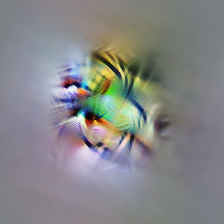

  2%|▏         | 10/512 [00:00<00:05, 92.59it/s]

negative


100%|██████████| 512/512 [00:06<00:00, 84.48it/s]



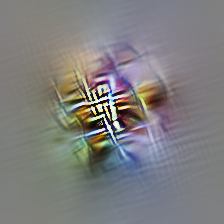

In [23]:
#visualization
from lucent_fresh.optvis import render, param, transform, objectives   #lucent fresh is a version of lucent with some of my edits
from lucent_fresh.modelzoo.util import get_model_layers


param_f = lambda: param.image(224)
obj  = objectives.neuron(layer,unit)

obj  = objectives.neuron(layer,0) #we use 0 as the unit now 


_ = minsquare_circuit['circuit'].to(device).eval()
print('positive')
_ = render.render_vis(minsquare_circuit['circuit'],  obj, param_f, transforms=None, show_inline=True)
print('negative')
_ = render.render_vis(minsquare_circuit['circuit'],  -obj, param_f, transforms=None, show_inline=True)

In [24]:
from circuit_pruner.force import TargetReached, get_saved_target_activations_from_net
import numpy as np


circuit_model = minsquare_circuit['circuit']

_ = circuit_model.to(device)

circuit_feature_targets = {layer:[0]}

setup_net_for_circuit_prune(circuit_model, feature_targets=circuit_feature_targets,save_target_activations=True)
#activations_list = []
#rotations_list = []
#sizes_list = []
activations = np.zeros((len(dset.sizes),len(dset.rotations)))

iter_dataloader = iter(square_loader)
iters = len(iter_dataloader)

for it in range(iters):

    inputs, img_data = next(iter_dataloader)
    inputs = inputs.to(device)
    try:
        output = circuit_model(inputs)
    except TargetReached:
        pass
    acts = get_saved_target_activations_from_net(circuit_model)[layer+':'+str(0)].cpu().detach().numpy().astype('float32')
    acts_at_pos = list(acts[:,target_position[0],target_position[1]])
    for i in range(len(acts_at_pos)):
        size_ind = dset.sizes.index(img_data[0].numpy()[i])
        rot_ind = dset.rotations.index(img_data[1].numpy()[i])
        activations[size_ind,rot_ind] = acts_at_pos[i]              
    #activations_list += list(acts_at_pos) 
    #sizes_list += list(img_data[0].numpy())
    #rotations_list += list(img_data[1].numpy())

features_8 effective last layer


In [25]:
import plotly.graph_objects as go

import pandas as pd



fig = go.Figure(data=[go.Surface(z=activations,x=dset.rotations, y=dset.sizes)])

fig.update_layout(title='circle feature activations to square (by rotation and size)',
                  scene = dict(
                    xaxis_title="Rotation (degrees)",
                    yaxis_title="Size",
                    zaxis_title='Activation'),
                    scene_aspectmode='cube')



fig.show()

In [26]:
fig.write_html("plots/circle_feature_rot12_square_circuit_acts.html")

### By weightsxgradients

weightsxgradients uses a slightly different api, and does not require a 'dissected_model' making everything faster, but the ranks aren't as good

In [4]:
from circuit_pruner.force import setup_net_for_circuit_prune, show_model_layer_names


_ = model.to('cpu')
prunable_model = deepcopy(model)
_ = prunable_model.to(device)
setup_net_for_circuit_prune(prunable_model)


In [6]:
layer = 'classifier_4'
unit = 10

feature_targets = {layer:[unit]}

100%|██████████| 512/512 [00:20<00:00, 24.57it/s]



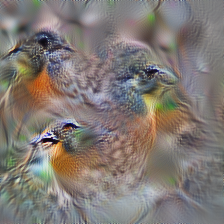

In [9]:
from lucent_fresh.optvis import render, param, transform, objectives   #lucent fresh is a version of lucent with some of my edits
from lucent_fresh.modelzoo.util import get_model_layers

param_f = lambda: param.image(224)
obj_pos  = objectives.channel(layer,unit)
obj_neg = -objectives.channel(layer,unit)
_ = render.render_vis(prunable_model,  'classifier_6:10', param_f, show_inline=True) #weird hack here using the 'dissected_model' works better for neuron-wise feature visualizations, not sure why

In [17]:
from circuit_pruner.data_loading import rank_image_data, single_image_data


#make single image data loaders

kwargs = {'num_workers': 4, 'pin_memory': True, 'sampler':None} if 'cuda' in device else {}


dataloaders = {'small':
    
}


side_face_image_loader = data.DataLoader(single_image_data(faces_path+side_img_name,
                                            config.preprocess,
                                            ),
                                            batch_size=1,
                                            shuffle=False,
                                            **kwargs)


front_face_image_loader = data.DataLoader(single_image_data(faces_path+front_img_name,
                                            config.preprocess,
                                            ),
                                            batch_size=1,
                                            shuffle=False,
                                            **kwargs)